**Problem Statement :**

The objective of this project is to predict whether an individual earns more than $50,000 annually using demographic and employment-related features from the Adult Census dataset.


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("/content/adult.csv.zip")

**Data Cleaning**

In [ ]:
df.shape

(32561, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:

df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [ ]:
df.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,0
relationship,0
race,0
sex,0


In [ ]:
df.nunique()

,0
age,73
workclass,9
fnlwgt,21648
education,16
education.num,16
marital.status,7
occupation,15
relationship,6
race,5
sex,2


In [ ]:

df.dtypes

,0
age,int64
workclass,object
fnlwgt,int64
education,object
education.num,int64
marital.status,object
occupation,object
relationship,object
race,object
sex,object


<Axes: >

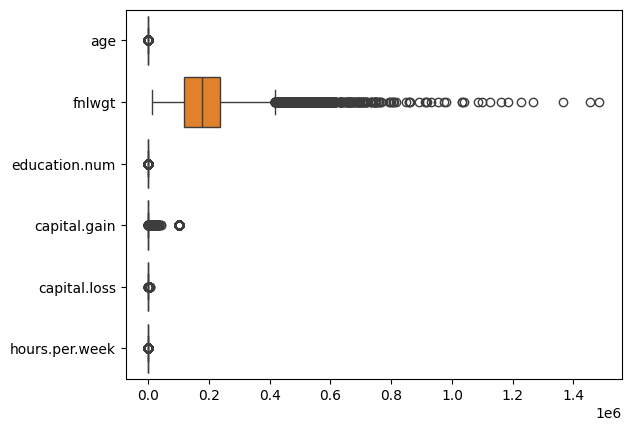

In [ ]:
import seaborn as sns
sns.boxplot(df,orient = "h")

In [ ]:
#  Removes the 'fnlwgt' column from the dataframe
#  Because 'fnlwgt' is not useful for our analysis or model
df = df.drop(columns=["fnlwgt"])

In [ ]:

df.duplicated().sum()


np.int64(3465)

In [ ]:

df = df.drop_duplicates()

In [ ]:
missing_count = (df['workclass'] == '?').sum()
print(f"Rows with ?: {missing_count}")

Rows with ?: 1632


In [ ]:
df.replace('?', np.nan, inplace=True)
# Fills missing values in these categorical columns with the mode
for col in ['workclass', 'occupation', 'native.country']:
    df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:


missing_count = (df['workclass'] == '?').sum()
print(f"Rows with ?: {missing_count}")

Rows with ?: 0


In [ ]:
df["workclass"].unique()

array(['Private', 'State-gov', 'Federal-gov', 'Self-emp-not-inc',
       'Self-emp-inc', 'Local-gov', 'Without-pay', 'Never-worked'],
      dtype=object)

In [ ]:

df["income"] = df["income"].astype(str).str.strip().str.replace('.', '', regex=False)
df["income"] = np.where(df["income"] == ">50K", 1, 0)

**Data Analysis**

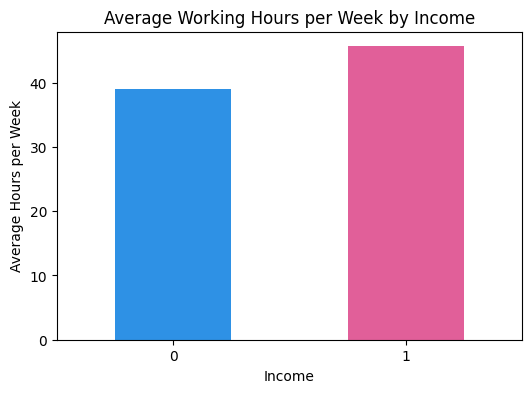

In [ ]:


## Average hours per week by Income
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

income_hours = df.groupby('income')['hours.per.week'].mean()

colors = ['#2E91E5', '#E15F99']
income_hours.plot(kind='bar', color=colors)

plt.title("Average Working Hours per Week by Income")
plt.xlabel("Income")
plt.ylabel("Average Hours per Week")
plt.xticks(rotation=0)
plt.show()

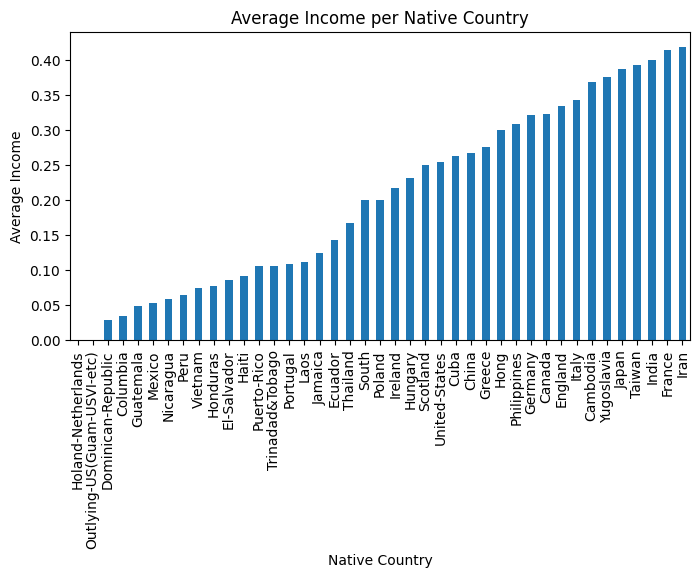

In [ ]:
## Average Income per Native Country
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

country_income = (
    df.groupby('native.country')['income']
      .mean()
      .sort_values()
)

country_income.plot(kind='bar')

plt.title("Average Income per Native Country")
plt.ylabel("Average Income")
plt.xlabel("Native Country")
plt.show()

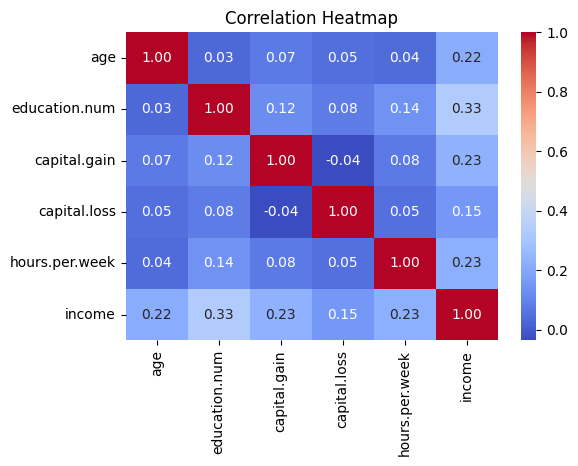

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))

num_cols = [
    'age',
    'education.num',
    'capital.gain',
    'capital.loss',
    'hours.per.week',
    'income'
]

sns.heatmap(
    df[num_cols].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)

plt.title("Correlation Heatmap")
plt.show()

**Target variable**

In [ ]:
X = df.drop("income", axis=1)
y = df["income"]
print(y.shape)
print(X.shape)

(29096,)
(29096, 13)


In [ ]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import pandas as pd

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:

print("Before SMOTE:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("y_train distribution:\n", y_train.value_counts())
print("Counter view:", Counter(y_train))

Before SMOTE:
X_train shape: (23276, 13)
y_train shape: (23276,)
y_train distribution:
 income
0    17508
1     5768
Name: count, dtype: int64
Counter view: Counter({0: 17508, 1: 5768})


In [ ]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

transformer = ColumnTransformer(transformers=[
    ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
    ("num", StandardScaler(), numerical_cols)
])

In [ ]:
pipeline = ImbPipeline(steps=[
    ("preprocessor", transformer),       # Encode + scale
    ("smote", SMOTE(random_state=42)),   # Oversample minority class
    ("knn", KNeighborsClassifier())      # Classifier
])

In [ ]:

best_knn = pipeline.fit(X_train, y_train)

In [ ]:
# Optional: Check resampled distribution
# Need to transform first before feeding to SMOTE
X_train_transformed = transformer.fit_transform(X_train)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train_transformed, y_train)
print("Resampled y distribution:\n", pd.Series(y_resampled).value_counts())

Resampled y distribution:
 income
0    17508
1    17508
Name: count, dtype: int64


- F1-macro : Measures model performance equally on all classes, making it suitable for imbalanced data.

- F1-weighted : Measures overall performance while giving more importance to the majority class.

**Hyper Parameter Tunning**

In [ ]:
knn_params = {
    "knn__n_neighbors": range(1, 21),
    "knn__p": [1, 2,3],
    "knn__weights": ["uniform", "distance"]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
knn_gs = GridSearchCV(
    estimator=pipeline,
    param_grid=knn_params,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

In [32]:
knn_gs.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'],
      dtype='object')),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         Index(['age', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object'))])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': range(1, 21), 'knn__p': [1, 2, 3],
                         'knn__weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)

In [33]:
knn_gs.best_params_,knn_gs.best_score_

({'knn__n_neighbors': 20, 'knn__p': 1, 'knn__weights': 'uniform'},
 np.float64(0.6600352580424491))

In [34]:
## # Pipeline with preprocessing and Decision Tree using the best tuned hyperparameters
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline # Added import
knn_pipe = Pipeline([("preprocessor",transformer),("knn", KNeighborsClassifier(
        n_neighbors=20,
        weights="distance",   # for imbalanced data i used distance
        p=1

    ))
])

knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['age', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object'))])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=20, p=1,
                                      weights='distance'))])

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = knn_pipe.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.90      0.88      4378
           1       0.64      0.53      0.58      1442

    accuracy                           0.81      5820
   macro avg       0.75      0.71      0.73      5820
weighted avg       0.80      0.81      0.80      5820



In [36]:
from sklearn.metrics import accuracy_score, f1_score

# Predict on test data
y_pred_knn = knn_pipe.predict(X_test)

# Print ONLY scores
print("KNN F1-score :", f1_score(y_test, y_pred_knn,average="macro"))

KNN F1-score : 0.7282883149195087


**Logistic Regression**

In [37]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score


In [38]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("lr", LogisticRegression(max_iter=2000))
])

In [39]:
param_grid = {
    "lr__C": [0.01, 0.1, 1, 10],
    "lr__penalty": ["l2"]
}

In [40]:
X_test_transformed = transformer.transform(X_test)

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_transformed, y_train)
print("LR Tuned Best Params:",grid.best_params_)
print("LR Tuned Test Acc :", grid.score(X_test_transformed, y_test))

LR Tuned Best Params: {'lr__C': 0.1, 'lr__penalty': 'l2'}
LR Tuned Test Acc : 0.61175147596289


In [41]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline # Ensure Pipeline is imported
from sklearn.linear_model import LogisticRegression # Ensure LogisticRegression is imported

log_pipe = Pipeline([
    ("preprocessor", transformer),
    ("lr", LogisticRegression(
        C = 0.01,
        penalty = "l2",
        max_iter=2000 # Add max_iter to prevent convergence warning
    ))
])

log_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['age', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object'))])),
                ('lr', LogisticRegression(C=0.01, max_iter=2000))])

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_log = log_pipe.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3959  419]
 [ 684  758]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      4378
           1       0.64      0.53      0.58      1442

    accuracy                           0.81      5820
   macro avg       0.75      0.71      0.73      5820
weighted avg       0.80      0.81      0.80      5820



In [43]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score
)
print("Precision:", precision_score(y_test,y_pred))
print("Recall   :", recall_score(y_test,y_pred))
print("F1 Score :", f1_score(y_test,y_pred,average="macro"))

Precision: 0.6440101954120646
Recall   : 0.5256588072122053
F1 Score : 0.7282883149195087


**SVM**

In [45]:
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ("preprocessor", transformer),
    ("smote", SMOTE(random_state=42)),
    ("svm", SVC(probability=True))
])
pipeline.fit(X_train, y_train)

print("SVM Train Accuracy:", pipeline.score(X_train, y_train))
print("SVM Test Accuracy:", pipeline.score(X_test, y_test))

SVM Train Accuracy: 0.7591510568826259
SVM Test Accuracy: 0.7527491408934708


**Hyperparameter Tuning**

In [46]:
param_grid = {
    "svm__kernel": ["rbf"],
    "svm__C": [1, 10],
    "svm__gamma": ["scale", 0.1]
}

In [47]:
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'],
      dtype='object')),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         Index(['age', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object'))])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 10], 'svm__gamma': ['scale', 0.1],
                         'svm__kernel': ['rbf']},
             scoring='f1_macro')

In [48]:
print("\nSVM Tuned Best Params:",grid.best_params_)


SVM Tuned Best Params: {'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In [49]:
final_svm_model = Pipeline([
    ("preprocessor", transformer),
    ("smote", SMOTE(random_state=42)),
    ("svm", SVC(
        kernel="rbf",
        C=1,
        gamma=0.01,  # replace with your tuned gamma
        probability=True,  # needed if you want ROC-AUC
        class_weight="balanced",  # important for imbalanced data
        random_state=42
    ))
])


In [50]:
# Train on full training set
final_svm_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['age', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('svm',
                 SVC(C=1, class_weight='balanced', gamma=0.01, probability=True,
                     random_state=42))])

In [51]:
# Predict
y_pred_svm = final_svm_model.predict(X_test)
print("SVM F1-score:", f1_score(y_test, y_pred_svm))

SVM F1-score: 0.6701369863013699


**Random Forest**

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf_pipe = Pipeline([
    ("preprocessor", transformer),
    ("rf", RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_pipe.fit(X_train, y_train)

print("Random Forest Train Accuracy:", rf_pipe.score(X_train, y_train))
print("Random Forest Test Accuracy:", rf_pipe.score(X_test, y_test))

Random Forest Train Accuracy: 0.9827719539439767
Random Forest Test Accuracy: 0.834192439862543


**Hyperparameter Tunning**

In [53]:
param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 20, 40],
    "rf__min_samples_split": [2, 5]
}

grid = GridSearchCV(
    rf_pipe,
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

In [54]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'],
      dtype='object')),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         Index(['age', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object'))])),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 20, 40],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 200]},
             scoring='f1_macro')

In [55]:
print("\nRF Tuned Best Params:", grid.best_params_)
print("RF Tuned CV Best F1 Score:", grid.best_score_)


RF Tuned Best Params: {'rf__max_depth': 20, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
RF Tuned CV Best F1 Score: 0.7987030967756242


In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, roc_auc_score

# Final Random Forest pipeline with tuned parameters
final_rf_model = Pipeline([
    ("preprocessor", transformer),
    ("rf", RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        class_weight="balanced"   # handle imbalanced target
    ))
])

# Train on full training data
final_rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['age', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object'))])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_split=5,
                                        random_state=42))])

In [57]:
y_pred_rf = final_rf_model.predict(X_test)

print("Random Forest F1-macro:", f1_score(y_test, y_pred_rf, average="macro"))
print("Random Forest F1-weighted:", f1_score(y_test, y_pred_rf, average="weighted"))

Random Forest F1-macro: 0.7962762109808824
Random Forest F1-weighted: 0.8427708292047703


- For imbalanced binary classification, I use F1-macro as the primary metric and apply SMOTE for distance-based and linear models, while using class_weight for tree-based models

**Gradient Boosting**

In [58]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8]
}

In [59]:
grid = GridSearchCV(
    gb,
    param_grid,
    scoring="f1_macro",  # best for imbalanced data
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [4, 6],
                         'n_estimators': [300, 500], 'subsample': [0.8]},
             scoring='f1_macro')

In [60]:
best_gb = grid.best_estimator_

In [61]:
y_pred_gb = best_gb.predict(X_test_transformed)

print("GradientBoosT F1-score:", f1_score(y_test, y_pred))


GradientBoosT F1-score: 0.5788468881252387


In [62]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

# Predictions
y_pred_gb = best_gb.predict(X_test_transformed)
y_proba_gb = best_gb.predict_proba(X_test_transformed)[:, 1]

print("Gradient Boosting Final Metrics")
print("F1 Score       :", f1_score(y_test, y_pred_gb))
print("ROC-AUC        :", roc_auc_score(y_test, y_proba_gb))
print("PR-AUC (BEST)  :", average_precision_score(y_test, y_proba_gb))


Gradient Boosting Final Metrics
F1 Score       : 0.7121729237770194
ROC-AUC        : 0.9238779954494449
PR-AUC (BEST)  : 0.8295996135025262


In [63]:
# Calculate scale_pos_weight (important for imbalance)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

**XGBoost**

In [64]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

# Base XGBoost pipeline
xgb_base_pipe = Pipeline([
    ("preprocessor", transformer),
    ("xgb", XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False
    ))
])

# Train base model
xgb_base_pipe.fit(X_train, y_train)

# Predict
y_pred_base = xgb_base_pipe.predict(X_test)

# Test score
print("Base XGB F1-score :", f1_score(y_test, y_pred_base, average="macro"))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:36:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Base XGB F1-score : 0.7945285821436668


In [65]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
xgb_params = {
    "xgb__n_estimators": [300, 500],
    "xgb__max_depth": [4, 6],
    "xgb__learning_rate": [0.05, 0.1],
    "xgb__subsample": [0.8],
    "xgb__colsample_bytree": [0.8],
    "xgb__min_child_weight": [1, 5],
    "xgb__gamma": [0, 0.1]
}

# GridSearchCV
xgb_grid = GridSearchCV(
    estimator=xgb_base_pipe,
    param_grid=xgb_params,
    cv=5,
    scoring="f1_macro",   # best for imbalanced data
    n_jobs=-1,
    verbose=1
)

# Fit grid
xgb_grid.fit(X_train, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:39:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'],
      dtype='object')),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         Index(['age', 'education.num', 'capit...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.8], 'xgb__gamma': [0, 0.1],
                         'xgb__learning_rate': [0.05, 0.1],
                         'xgb__max_depth': [4, 6],
                         'xgb__min_child_weight': [1, 5],
                         'xgb__n_estimators': [300, 500],
                         'xgb__subsample': [0.8]},
             scoring='f1_macro', verbose=1)

In [66]:
print("Best Parameters:")
print(xgb_grid.best_params_)


Best Parameters:
{'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 500, 'xgb__subsample': 0.8}


In [67]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

final_xgb_pipe = Pipeline([
    ("preprocessor", transformer),
    ("xgb", XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight,

        # Best tuned parameters
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        gamma=0
    ))
])


In [68]:
final_xgb_pipe.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:39:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['age', 'education.num', 'capital.gain', 'capital.loss',
       'hou...
                               feature_types=None, feature_weights=None,
                               gamma=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=500,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [69]:
y_pred_final = final_xgb_pipe.predict(X_test)

print("Final XGB F1-score :", f1_score(y_test, y_pred_final, average="macro"))


Final XGB F1-score : 0.7995960931568264


In [70]:
import pandas as pd
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score
)

# Ensure X_test_transformed is available for models that were trained on it directly
# This is needed for Gradient Boosting, which was trained on already transformed data.
X_test_transformed = transformer.transform(X_test)

# Re-run predictions for each model and store them in unique variables
# KNN (best_knn is the ImbPipeline from oIxt5I8-SDrd which includes the preprocessor and was fitted in Zy5SV5XXSZVc)
y_pred_knn = best_knn.predict(X_test) # Input X_test DataFrame as pipeline has preprocessor
y_proba_knn = best_knn.predict_proba(X_test)[:, 1]

# Logistic Regression (log_pipe from yMlswJQVbdbI, includes preprocessor)
# Using log_pipe as best_lr was deleted and log_pipe is the final LR pipeline with preprocessor.
y_pred_lr = log_pipe.predict(X_test) # Input X_test DataFrame as pipeline has preprocessor
y_proba_lr = log_pipe.predict_proba(X_test)[:, 1]

# SVM (final_svm_model from BBqRz1LJwvut, includes preprocessor)
# Using final_svm_model as best_svm was deleted.
y_pred_svm = final_svm_model.predict(X_test) # Input X_test DataFrame as pipeline has preprocessor
y_proba_svm = final_svm_model.predict_proba(X_test)[:, 1]

# Random Forest (final_rf_model from gxUPkHPW0fBt, includes preprocessor)
# Using final_rf_model as best_rf was deleted.
y_pred_rf = final_rf_model.predict(X_test) # Input X_test DataFrame as pipeline has preprocessor
y_proba_rf = final_rf_model.predict_proba(X_test)[:, 1]

# Gradient Boosting (best_gb from NVxEj22YS6wp, trained on X_train_transformed directly)
y_pred_gb = best_gb.predict(X_test_transformed) # Input X_test_transformed as model was trained without pipeline preprocessor
y_proba_gb = best_gb.predict_proba(X_test_transformed)[:, 1]

# XGBoost (final_xgb_pipe from lU87HUVU9SBU, includes preprocessor)
# Using final_xgb_pipe as best_xgb was deleted.
y_pred_xgb = final_xgb_pipe.predict(X_test) # Input X_test DataFrame as pipeline has preprocessor
y_proba_xgb = final_xgb_pipe.predict_proba(X_test)[:, 1]


final_report = pd.DataFrame({
    "Model": ["KNN", "Logistic Regression", "SVM", "Random Forest", "Gradient Boosting", "XGBoost"],

    "F1 (binary)": [
        f1_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_gb),
        f1_score(y_test, y_pred_xgb)
    ],

    "F1_macro": [
        f1_score(y_test, y_pred_knn, average="macro"),
        f1_score(y_test, y_pred_lr, average="macro"),
        f1_score(y_test, y_pred_svm, average="macro"),
        f1_score(y_test, y_pred_rf, average="macro"),
        f1_score(y_test, y_pred_gb, average="macro"),
        f1_score(y_test, y_pred_xgb, average="macro")
    ],

    "F1_weighted": [
        f1_score(y_test, y_pred_knn, average="weighted"),
        f1_score(y_test, y_pred_lr, average="weighted"),
        f1_score(y_test, y_pred_svm, average="weighted"),
        f1_score(y_test, y_pred_rf, average="weighted"),
        f1_score(y_test, y_pred_gb, average="weighted"),
        f1_score(y_test, y_pred_xgb, average="weighted")
    ],

    "Precision": [
        precision_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_svm),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_gb),
        precision_score(y_test, y_pred_xgb)
    ],

    "Recall": [
        recall_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_gb),
        recall_score(y_test, y_pred_xgb)
    ],

    "ROC-AUC": [
        roc_auc_score(y_test, y_proba_knn),
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_svm),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_gb),
        roc_auc_score(y_test, y_proba_xgb)
    ],

    "PR-AUC": [
        average_precision_score(y_test, y_proba_knn),
        average_precision_score(y_test, y_proba_lr),
        average_precision_score(y_test, y_proba_svm),
        average_precision_score(y_test, y_proba_rf),
        average_precision_score(y_test, y_proba_gb),
        average_precision_score(y_test, y_proba_xgb)
    ]
})

final_report

,Model,F1 (binary),F1_macro,F1_weighted,Precision,Recall,ROC-AUC,PR-AUC
0,KNN,0.626415,0.734684,0.789302,0.538692,0.748266,0.833077,0.572508
1,Logistic Regression,0.529720,0.707332,0.796932,0.716312,0.420250,0.842497,0.675173
2,SVM,0.670137,0.759724,0.804918,0.553895,0.848128,0.889688,0.744485
3,Random Forest,0.704110,0.796276,0.842771,0.642980,0.778086,0.911039,0.800609
4,Gradient Boosting,0.712173,0.813934,0.865269,0.785774,0.651179,0.923878,0.829600
5,XGBoost,0.715302,0.799596,0.842119,0.624870,0.836338,0.923671,0.828681


In [71]:
display(final_report)

,Model,F1 (binary),F1_macro,F1_weighted,Precision,Recall,ROC-AUC,PR-AUC
0,KNN,0.626415,0.734684,0.789302,0.538692,0.748266,0.833077,0.572508
1,Logistic Regression,0.529720,0.707332,0.796932,0.716312,0.420250,0.842497,0.675173
2,SVM,0.670137,0.759724,0.804918,0.553895,0.848128,0.889688,0.744485
3,Random Forest,0.704110,0.796276,0.842771,0.642980,0.778086,0.911039,0.800609
4,Gradient Boosting,0.712173,0.813934,0.865269,0.785774,0.651179,0.923878,0.829600
5,XGBoost,0.715302,0.799596,0.842119,0.624870,0.836338,0.923671,0.828681


ROC-AUC (Reciver operatig charactarstic - Area under curve)

PR-AUC (Area under the Precision-Recall curve) which used for imbalanced data

In [73]:
from sklearn.pipeline import Pipeline
import joblib

gb_pipeline = Pipeline(steps=[
    ("preprocessing", transformer),
    ("model", best_gb)
])

gb_pipeline.fit(X_train, y_train)

joblib.dump(gb_pipeline, "gradient_boosting.joblib")

print("Gradient Boosting pipeline saved successfully!")



Gradient Boosting pipeline saved successfully!
